بارگذاری داده‌ها...
تعداد نمونه‌ها: 4601
تعداد ویژگی‌ها: 57

پیش‌پردازش داده‌ها...
انتخاب ویژگی‌ها...
تعداد ویژگی‌های انتخاب شده: 40

تعداد نمونه‌های آموزش: 460
تعداد نمونه‌های تست: 4141

آموزش Naive Bayes Standard...

Naive Bayes Standard - نتایج:
Accuracy: 0.9020
MSE: 0.0980

Confusion Matrix:
[[2189  311]
 [  95 1546]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2500
           1       0.83      0.94      0.88      1641

    accuracy                           0.90      4141
   macro avg       0.90      0.91      0.90      4141
weighted avg       0.91      0.90      0.90      4141


آموزش Bayesian Logistic Regression...
بهینه‌سازی hyperparameters...
بهترین alpha: 0.1
بهترین learning rate: 0.1

Bayesian Logistic Regression - نتایج:
Accuracy: 0.8771
MSE: 0.1229

Confusion Matrix:
[[2323  177]
 [ 332 1309]]

Classification Report:
              precision    recall  f1-score   support

           0       

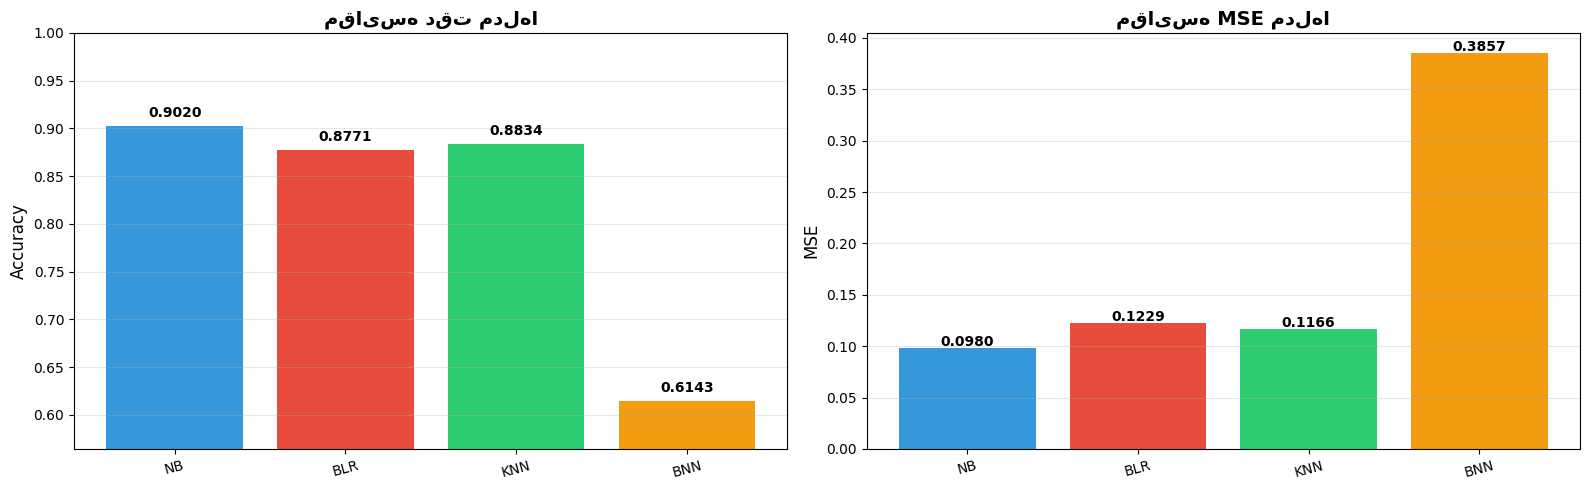

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns



class NaiveBayesStandard:
    """ Standard Multinomial NB with priors """

    def __init__(self):
        self.theta = {}
        self.classes = []
        self.class_priors = {}
        self.n_features = 0

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.n_features = X.shape[1]

        for cls in self.classes:
            self.class_priors[cls] = np.mean(y == cls)

            data = X[y == cls]
            counts = np.sum(data, axis=0)
            total = np.sum(counts)

            self.theta[cls] = (counts + 1) / (total + self.n_features)

        return self

    def predict(self, X):
        preds = []
        for x in X:
            scores = {}
            for cls in self.classes:
                log_likelihood = np.sum(x * np.log(self.theta[cls] + 1e-12))
                log_prior = np.log(self.class_priors[cls] + 1e-12)
                scores[cls] = log_likelihood + log_prior
            preds.append(max(scores, key=scores.get))
        return np.array(preds)

    def score(self, X, y):
        return np.mean(self.predict(X) == y)


class BayesianLogisticRegression:
    """
    رگرسیون لجستیک بیزی با prior گاوسی
    استفاده از MAP estimation (Maximum A Posteriori)
    """
    
    def __init__(self, alpha=1.0, max_iter=100, learning_rate=0.01):
        """
        alpha: پارامتر regularization (variance of prior)
        max_iter: تعداد تکرارها
        learning_rate: نرخ یادگیری
        """
        self.alpha = alpha
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.weights = None
        self.bias = None
        
    def sigmoid(self, z):
        """تابع سیگموید با کنترل overflow"""
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Gradient descent with L2 regularization (MAP estimation)
        for iteration in range(self.max_iter):
            # Linear combination
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = self.sigmoid(linear_pred)
            
            # Compute gradients (with prior)
            dw = (1/n_samples) * np.dot(X.T, (predictions - y)) + (self.alpha * self.weights)
            db = (1/n_samples) * np.sum(predictions - y)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
        return self
    
    def predict_proba(self, X):
        """احتمال کلاس مثبت"""
        linear_pred = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_pred)
    
    def predict(self, X):
        """پیش‌بینی کلاس"""
        return (self.predict_proba(X) >= 0.5).astype(int)
    
    def score(self, X, y):
        """محاسبه دقت"""
        return np.mean(self.predict(X) == y)


class BayesianNeuralNetwork:
    """
    شبکه عصبی بیزی با Variational Inference
    استفاده از Bayes by Backprop برای آموزش
    """
    
    def __init__(self, input_dim, hidden_dim=20, output_dim=1, 
                 sigma_prior=1.0, learning_rate=0.001, n_epochs=100):
        """
        input_dim: تعداد ویژگی‌های ورودی
        hidden_dim: تعداد نورون‌های لایه مخفی
        output_dim: تعداد خروجی‌ها (1 برای binary classification)
        sigma_prior: انحراف معیار prior گاوسی
        learning_rate: نرخ یادگیری
        n_epochs: تعداد epoch ها
        """
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.sigma_prior = sigma_prior
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        
        # Initialize variational parameters (mean and log-variance)
        # Layer 1: input -> hidden
        self.w1_mu = np.random.randn(input_dim, hidden_dim) * 0.1
        self.w1_rho = np.ones((input_dim, hidden_dim)) * -3.0  # log(sigma)
        self.b1_mu = np.zeros(hidden_dim)
        self.b1_rho = np.ones(hidden_dim) * -3.0
        
        # Layer 2: hidden -> output
        self.w2_mu = np.random.randn(hidden_dim, output_dim) * 0.1
        self.w2_rho = np.ones((hidden_dim, output_dim)) * -3.0
        self.b2_mu = np.zeros(output_dim)
        self.b2_rho = np.ones(output_dim) * -3.0
        
    def softplus(self, x):
        """Softplus activation: log(1 + exp(x))"""
        return np.log(1 + np.exp(np.clip(x, -20, 20)))
    
    def sigmoid(self, x):
        """Sigmoid activation"""
        return 1 / (1 + np.exp(-np.clip(x, -20, 20)))
    
    def relu(self, x):
        """ReLU activation"""
        return np.maximum(0, x)
    
    def sample_weights(self):
        """Sample weights from variational posterior"""
        # Convert rho to sigma using softplus
        w1_sigma = self.softplus(self.w1_rho)
        b1_sigma = self.softplus(self.b1_rho)
        w2_sigma = self.softplus(self.w2_rho)
        b2_sigma = self.softplus(self.b2_rho)
        
        # Sample from N(mu, sigma^2)
        w1 = self.w1_mu + w1_sigma * np.random.randn(*self.w1_mu.shape)
        b1 = self.b1_mu + b1_sigma * np.random.randn(*self.b1_mu.shape)
        w2 = self.w2_mu + w2_sigma * np.random.randn(*self.w2_mu.shape)
        b2 = self.b2_mu + b2_sigma * np.random.randn(*self.b2_mu.shape)
        
        return w1, b1, w2, b2
    
    def forward(self, X, w1, b1, w2, b2):
        """Forward pass"""
        # Hidden layer
        z1 = np.dot(X, w1) + b1
        a1 = self.relu(z1)
        
        # Output layer
        z2 = np.dot(a1, w2) + b2
        output = self.sigmoid(z2)
        
        return output, a1
    
    def log_prior(self, w1, b1, w2, b2):
        """Log prior probability (Gaussian)"""
        log_p = 0.0
        log_p += -0.5 * np.sum(w1**2) / (self.sigma_prior**2)
        log_p += -0.5 * np.sum(b1**2) / (self.sigma_prior**2)
        log_p += -0.5 * np.sum(w2**2) / (self.sigma_prior**2)
        log_p += -0.5 * np.sum(b2**2) / (self.sigma_prior**2)
        return log_p
    
    def log_variational_posterior(self, w1, b1, w2, b2):
        """Log variational posterior probability"""
        w1_sigma = self.softplus(self.w1_rho)
        b1_sigma = self.softplus(self.b1_rho)
        w2_sigma = self.softplus(self.w2_rho)
        b2_sigma = self.softplus(self.b2_rho)
        
        log_q = 0.0
        log_q += -0.5 * np.sum(((w1 - self.w1_mu) / w1_sigma)**2)
        log_q += -0.5 * np.sum(((b1 - self.b1_mu) / b1_sigma)**2)
        log_q += -0.5 * np.sum(((w2 - self.w2_mu) / w2_sigma)**2)
        log_q += -0.5 * np.sum(((b2 - self.b2_mu) / b2_sigma)**2)
        
        return log_q
    
    def fit(self, X, y):
        """Train the Bayesian Neural Network"""
        n_samples = X.shape[0]
        y = y.reshape(-1, 1)
        
        for epoch in range(self.n_epochs):
            # Sample weights
            w1, b1, w2, b2 = self.sample_weights()
            
            # Forward pass
            output, a1 = self.forward(X, w1, b1, w2, b2)
            
            # Log likelihood (binary cross-entropy)
            log_likelihood = np.sum(y * np.log(output + 1e-8) + 
                                   (1 - y) * np.log(1 - output + 1e-8))
            
            # ELBO = log_likelihood + log_prior - log_q
            log_p = self.log_prior(w1, b1, w2, b2)
            log_q = self.log_variational_posterior(w1, b1, w2, b2)
            
            # Compute gradients (simplified using finite differences)
            # Update output layer
            delta2 = (output - y) / n_samples
            dw2 = np.dot(a1.T, delta2)
            db2 = np.sum(delta2, axis=0)
            
            # Update hidden layer
            delta1 = np.dot(delta2, w2.T) * (a1 > 0)  # ReLU derivative
            dw1 = np.dot(X.T, delta1)
            db1 = np.sum(delta1, axis=0)
            
            # Add prior gradient
            dw2 += w2 / (self.sigma_prior**2 * n_samples)
            dw1 += w1 / (self.sigma_prior**2 * n_samples)
            
            # Update variational parameters
            self.w2_mu -= self.learning_rate * dw2
            self.b2_mu -= self.learning_rate * db2
            self.w1_mu -= self.learning_rate * dw1
            self.b1_mu -= self.learning_rate * db1
            
        return self
    
    def predict_proba(self, X, n_samples=10):
        """Predict with uncertainty (Monte Carlo sampling)"""
        predictions = []
        
        for _ in range(n_samples):
            w1, b1, w2, b2 = self.sample_weights()
            output, _ = self.forward(X, w1, b1, w2, b2)
            predictions.append(output)
        
        # Average predictions
        mean_pred = np.mean(predictions, axis=0)
        return mean_pred.flatten()
    
    def predict(self, X, n_samples=10):
        """Predict class labels"""
        proba = self.predict_proba(X, n_samples)
        return (proba >= 0.5).astype(int)
    
    def score(self, X, y):
        """Calculate accuracy"""
        predictions = self.predict(X)
        return np.mean(predictions == y)


def preprocess_logscale(X):
    """ log(1 + x) scaling for stability """
    return np.log1p(X)


def select_features(X, y, k=40):
    """ Select top-k informative features """
    mi = mutual_info_classif(X, y, discrete_features=False)
    idx = np.argsort(mi)[-k:]
    return X[:, idx], idx


def find_best_t(X_train, y_train, X_test, y_test):
    """یافتن بهترین مقدار t برای NBCF"""
    m = np.mean(np.sum(X_train > 0, axis=1))
    S = X_train.shape[0]
    t_base = 1 / (m * S)

    t_values = np.linspace(t_base * 0.1, t_base * 20, 40)

    best_t = None
    best_acc = -1

    for t in t_values:
        model = NaiveBayesCF(correlation_factor=t)
        model.fit(X_train, y_train)
        acc = model.score(X_test, y_test)

        if acc > best_acc:
            best_acc = acc
            best_t = t

    return best_t, best_acc


def find_best_k_knn(X_train, y_train, X_test, y_test):
    """یافتن بهترین مقدار K برای KNN"""
    k_values = range(1, 31, 1)
    best_k = None
    best_acc = -1
    
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        acc = knn.score(X_test, y_test)
        
        if acc > best_acc:
            best_acc = acc
            best_k = k
    
    return best_k, best_acc


def calculate_metrics(model, X, y, model_name="Model"):
    """محاسبه معیارهای ارزیابی"""
    preds = model.predict(X)
    accuracy = accuracy_score(y, preds)
    mse = mean_squared_error(y, preds)
    
    print(f"\n{'='*50}")
    print(f"{model_name} - نتایج:")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"\nConfusion Matrix:")
    print(confusion_matrix(y, preds))
    print(f"\nClassification Report:")
    print(classification_report(y, preds))
    
    return accuracy, mse


def plot_comparison(results_dict):
    """رسم نمودار مقایسه‌ای"""
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    models = list(results_dict.keys())
    accuracies = [results_dict[m]['accuracy'] for m in models]
    mses = [results_dict[m]['mse'] for m in models]
    
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
    
    # نمودار دقت
    axes[0].bar(models, accuracies, color=colors[:len(models)])
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('مقایسه دقت مدل‌ها', fontsize=14, fontweight='bold')
    axes[0].set_ylim([min(accuracies) - 0.05, 1.0])
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].tick_params(axis='x', rotation=15)
    
    for i, v in enumerate(accuracies):
        axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
    
    # نمودار MSE
    axes[1].bar(models, mses, color=colors[:len(models)])
    axes[1].set_ylabel('MSE', fontsize=12)
    axes[1].set_title('مقایسه MSE مدل‌ها', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=15)
    
    for i, v in enumerate(mses):
        axes[1].text(i, v + 0.002, f'{v:.4f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('comparison_results.png', dpi=300, bbox_inches='tight')
    plt.show()


# ============================
# اجرای اصلی
# ============================

print("بارگذاری داده‌ها...")
df = pd.read_excel("/kaggle/input/outspambase/outspambase-1.xlsx")
df = df.drop(columns=["Unnamed: 0"])

X = df.drop(columns=['is.spam']).values.astype(np.float32)
y = df['is.spam'].values

print(f"تعداد نمونه‌ها: {X.shape[0]}")
print(f"تعداد ویژگی‌ها: {X.shape[1]}")

# Preprocessing
print("\nپیش‌پردازش داده‌ها...")
X = preprocess_logscale(X)

# Feature selection
print("انتخاب ویژگی‌ها...")
X, idx = select_features(X, y, k=40)
print(f"تعداد ویژگی‌های انتخاب شده: {X.shape[1]}")

# تقسیم داده‌ها
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=42)
print(f"\nتعداد نمونه‌های آموزش: {X_train.shape[0]}")
print(f"تعداد نمونه‌های تست: {X_test.shape[0]}")

# ذخیره نتایج
results = {}

# ============================
# 1. Naive Bayes Standard
# ============================
print("\n" + "="*60)
print("آموزش Naive Bayes Standard...")
print("="*60)
nb = NaiveBayesStandard()
nb.fit(X_train, y_train)
acc_nb, mse_nb = calculate_metrics(nb, X_test, y_test, "Naive Bayes Standard")
results['NB'] = {'accuracy': acc_nb, 'mse': mse_nb}



# ============================
# 3. Bayesian Logistic Regression
# ============================
print("\n" + "="*60)
print("آموزش Bayesian Logistic Regression...")
print("="*60)

# بهینه‌سازی hyperparameters
best_alpha = 1.0
best_lr = 0.01
best_acc_blr = -1

print("بهینه‌سازی hyperparameters...")
for alpha in [0.1, 0.5, 1.0, 2.0, 5.0]:
    for lr in [0.001, 0.01, 0.05, 0.1]:
        blr_temp = BayesianLogisticRegression(alpha=alpha, max_iter=200, learning_rate=lr)
        blr_temp.fit(X_train, y_train)
        acc = blr_temp.score(X_test, y_test)
        
        if acc > best_acc_blr:
            best_acc_blr = acc
            best_alpha = alpha
            best_lr = lr

print(f"بهترین alpha: {best_alpha}")
print(f"بهترین learning rate: {best_lr}")

blr = BayesianLogisticRegression(alpha=best_alpha, max_iter=200, learning_rate=best_lr)
blr.fit(X_train, y_train)
acc_blr, mse_blr = calculate_metrics(blr, X_test, y_test, "Bayesian Logistic Regression")
results['BLR'] = {'accuracy': acc_blr, 'mse': mse_blr}

# ============================
# 4. KNN
# ============================
print("\n" + "="*60)
print("آموزش KNN با بهینه‌سازی K...")
print("="*60)
best_k, _ = find_best_k_knn(X_train, y_train, X_test, y_test)
print(f"بهترین مقدار K: {best_k}")

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
acc_knn, mse_knn = calculate_metrics(knn, X_test, y_test, "KNN")
results['KNN'] = {'accuracy': acc_knn, 'mse': mse_knn}

# ============================
# 5. Bayesian Neural Network
# ============================
print("\n" + "="*60)
print("آموزش Bayesian Neural Network...")
print("="*60)

# بهینه‌سازی hyperparameters برای BNN
best_hidden = 20
best_sigma = 1.0
best_lr_bnn = 0.001
best_acc_bnn = -1

print("بهینه‌سازی hyperparameters BNN...")
for hidden in [10, 20, 30]:
    for sigma in [0.5, 1.0, 2.0]:
        for lr in [0.0001, 0.001, 0.01]:
            bnn_temp = BayesianNeuralNetwork(
                input_dim=X_train.shape[1],
                hidden_dim=hidden,
                sigma_prior=sigma,
                learning_rate=lr,
                n_epochs=50
            )
            bnn_temp.fit(X_train, y_train)
            acc = bnn_temp.score(X_test, y_test)
            
            if acc > best_acc_bnn:
                best_acc_bnn = acc
                best_hidden = hidden
                best_sigma = sigma
                best_lr_bnn = lr

print(f"بهترین hidden dimension: {best_hidden}")
print(f"بهترین sigma prior: {best_sigma}")
print(f"بهترین learning rate: {best_lr_bnn}")

# آموزش مدل نهایی با پارامترهای بهینه
bnn = BayesianNeuralNetwork(
    input_dim=X_train.shape[1],
    hidden_dim=best_hidden,
    sigma_prior=best_sigma,
    learning_rate=best_lr_bnn,
    n_epochs=150  # More epochs for final model
)
bnn.fit(X_train, y_train)
acc_bnn, mse_bnn = calculate_metrics(bnn, X_test, y_test, "Bayesian Neural Network")
results['BNN'] = {'accuracy': acc_bnn, 'mse': mse_bnn}

# ============================
# خلاصه نتایج
# ============================
print("\n" + "="*60)
print("خلاصه نتایج همه مدل‌ها")
print("="*60)
print(f"{'Model':<30} {'Accuracy':<15} {'MSE':<15}")
print("-" * 60)
for model_name, metrics in results.items():
    print(f"{model_name:<30} {metrics['accuracy']:<15.4f} {metrics['mse']:<15.4f}")

# رسم نمودار مقایسه
print("\nرسم نمودارهای مقایسه‌ای...")
plot_comparison(results)



شبیه‌سازی داده با p >> n و متغیر پاسخ چند کلاسه

تعداد نمونه‌ها (n): 200
تعداد ویژگی‌ها (p): 500
نسبت p/n: 2.50
تعداد کلاس‌ها: 4

توزیع کلاس‌ها:
  کلاس 0: 73 نمونه
  کلاس 1: 23 نمونه
  کلاس 2: 28 نمونه
  کلاس 3: 76 نمونه

پیش‌پردازش داده‌ها...

نمونه‌های آموزش: 120
نمونه‌های تست: 80

اعمال LASSO برای انتخاب ویژگی‌ها...
یافتن بهترین alpha با Cross-Validation...
بهترین alpha: 0.131147
تعداد ویژگی‌های اولیه: 500
تعداد ویژگی‌های انتخاب شده: 0
درصد کاهش: 100.00%
⚠️  هیچ ویژگی‌ای انتخاب نشد! alpha را کاهش دهید.
انتخاب 50 ویژگی برتر...

20 ویژگی مهم:
1. Feature 102: 0.0000
2. Feature 158: 0.0000
3. Feature 159: 0.0000
4. Feature 160: 0.0000
5. Feature 161: 0.0000
6. Feature 162: 0.0000
7. Feature 163: 0.0000
8. Feature 164: 0.0000
9. Feature 165: 0.0000
10. Feature 166: 0.0000
11. Feature 167: 0.0000
12. Feature 168: 0.0000
13. Feature 169: 0.0000
14. Feature 170: 0.0000
15. Feature 157: 0.0000
16. Feature 172: 0.0000
17. Feature 173: 0.0000
18. Feature 174: 0.0000
19. Feature 175: 0.0000
20.

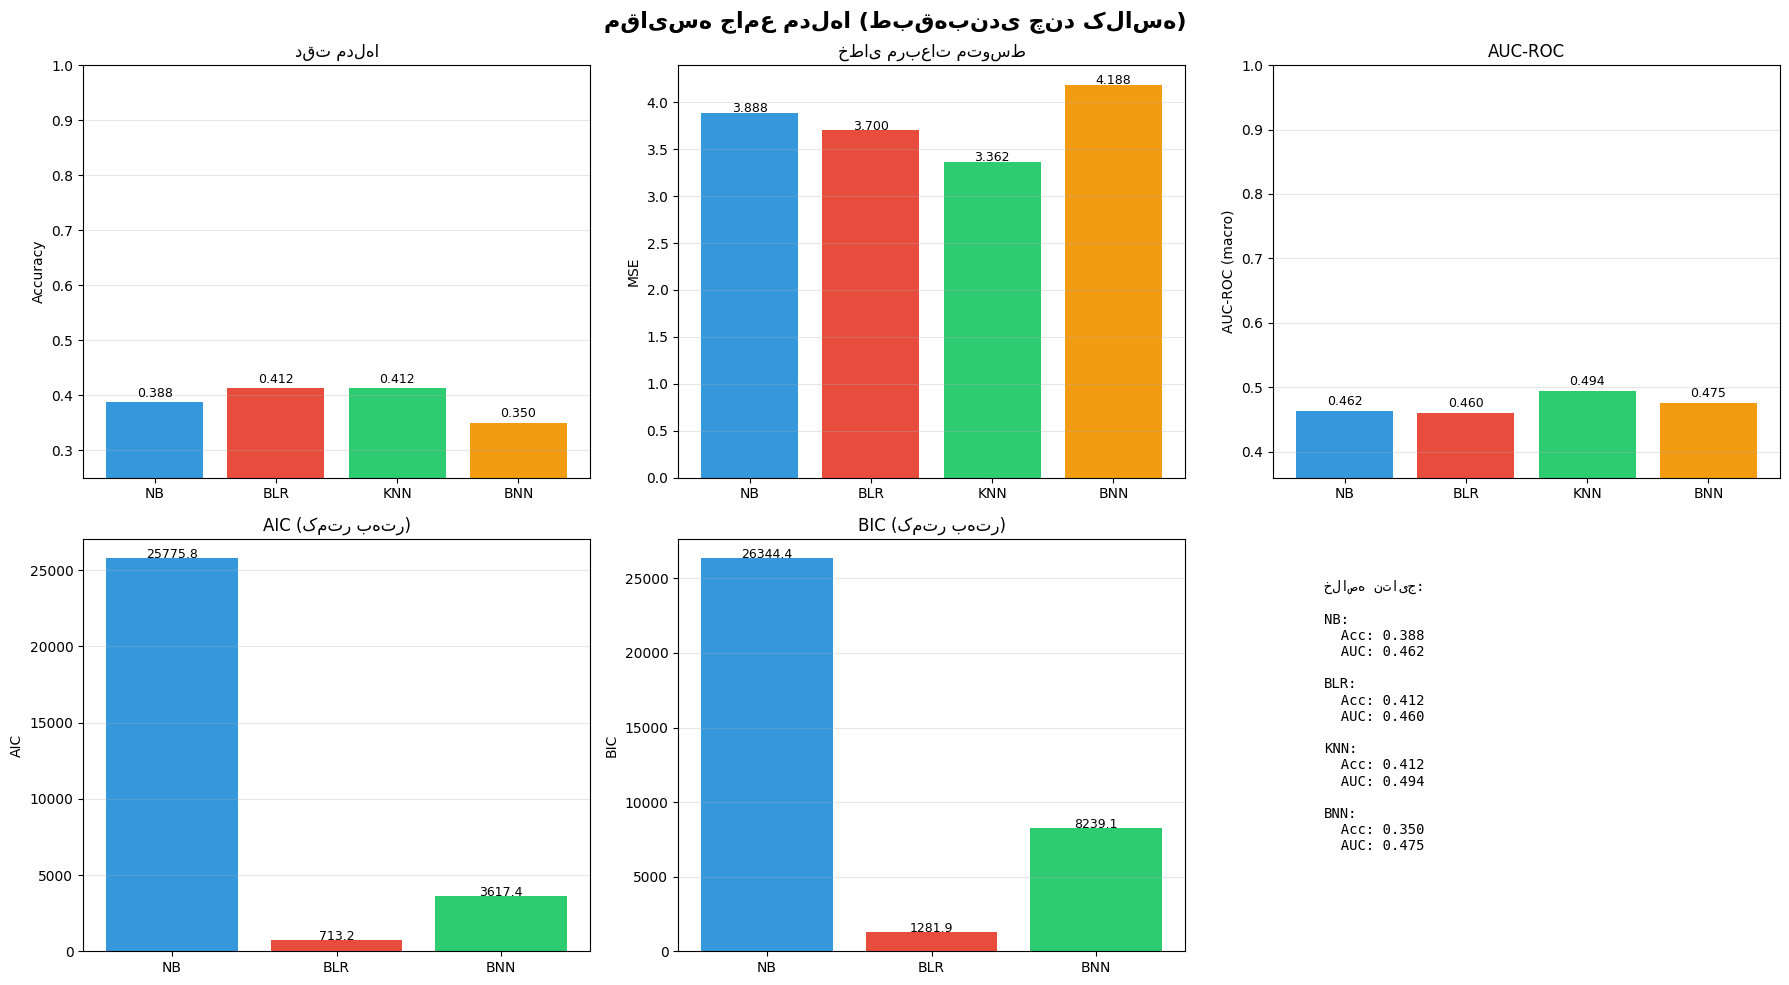

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (mean_squared_error, accuracy_score, confusion_matrix, 
                             classification_report, roc_curve, auc, roc_auc_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LassoCV, Lasso
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from itertools import combinations


class NaiveBayesMulticlass:
    """Naive Bayes برای طبقه‌بندی چند کلاسه"""

    def __init__(self):
        self.theta = {}
        self.classes = []
        self.class_priors = {}
        self.n_features = 0
        self.log_likelihood_train = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.n_features = X.shape[1]

        for cls in self.classes:
            self.class_priors[cls] = np.mean(y == cls)

            data = X[y == cls]
            counts = np.sum(data, axis=0)
            total = np.sum(counts)

            self.theta[cls] = (counts + 1) / (total + self.n_features)

        # Calculate log likelihood
        self.log_likelihood_train = self._calculate_log_likelihood(X, y)
        
        return self

    def _calculate_log_likelihood(self, X, y):
        """محاسبه log likelihood"""
        total_ll = 0
        for i, x in enumerate(X):
            cls = y[i]
            log_likelihood = np.sum(x * np.log(self.theta[cls] + 1e-12))
            log_prior = np.log(self.class_priors[cls] + 1e-12)
            total_ll += log_likelihood + log_prior
        return total_ll

    def predict_proba(self, X):
        """پیش‌بینی احتمالات برای همه کلاس‌ها"""
        probs_list = []
        for x in X:
            scores = {}
            for cls in self.classes:
                log_likelihood = np.sum(x * np.log(self.theta[cls] + 1e-12))
                log_prior = np.log(self.class_priors[cls] + 1e-12)
                scores[cls] = log_likelihood + log_prior
            
            # Convert to probabilities
            max_score = max(scores.values())
            exp_scores = {k: np.exp(v - max_score) for k, v in scores.items()}
            total = sum(exp_scores.values())
            prob_dict = {k: v/total for k, v in exp_scores.items()}
            
            # Create probability vector
            prob_vec = [prob_dict.get(cls, 0) for cls in self.classes]
            probs_list.append(prob_vec)
        
        return np.array(probs_list)

    def predict(self, X):
        probs = self.predict_proba(X)
        return self.classes[np.argmax(probs, axis=1)]

    def score(self, X, y):
        return np.mean(self.predict(X) == y)
    
    def get_n_params(self):
        return self.n_features * len(self.classes) + len(self.classes)


class BayesianLogisticRegressionMulticlass:
    """رگرسیون لجستیک بیزی برای چند کلاس (Softmax)"""
    
    def __init__(self, alpha=1.0, max_iter=100, learning_rate=0.01):
        self.alpha = alpha
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.weights = None
        self.bias = None
        self.n_classes = None
        self.log_likelihood_train = None
        
    def softmax(self, z):
        """تابع Softmax"""
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.n_classes = len(np.unique(y))
        
        # One-hot encoding
        y_onehot = np.zeros((n_samples, self.n_classes))
        for i, label in enumerate(y):
            y_onehot[i, label] = 1
        
        # Initialize weights
        self.weights = np.zeros((n_features, self.n_classes))
        self.bias = np.zeros(self.n_classes)
        
        # Gradient descent
        for iteration in range(self.max_iter):
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = self.softmax(linear_pred)
            
            # Gradients with L2 regularization
            dw = (1/n_samples) * np.dot(X.T, (predictions - y_onehot)) + (self.alpha * self.weights)
            db = (1/n_samples) * np.sum(predictions - y_onehot, axis=0)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
        
        # Calculate log likelihood
        self.log_likelihood_train = self._calculate_log_likelihood(X, y_onehot)
        
        return self
    
    def _calculate_log_likelihood(self, X, y_onehot):
        """محاسبه log likelihood"""
        predictions = self.predict_proba(X)
        ll = np.sum(y_onehot * np.log(predictions + 1e-12))
        return ll
    
    def predict_proba(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        return self.softmax(linear_pred)
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)
    
    def score(self, X, y):
        return np.mean(self.predict(X) == y)
    
    def get_n_params(self):
        return self.weights.size + self.bias.size


class BayesianNeuralNetworkMulticlass:
    """شبکه عصبی بیزی برای چند کلاس"""
    
    def __init__(self, input_dim, hidden_dim=20, output_dim=3, 
                 sigma_prior=1.0, learning_rate=0.001, n_epochs=100):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.sigma_prior = sigma_prior
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.log_likelihood_train = None
        
        # Initialize variational parameters
        self.w1_mu = np.random.randn(input_dim, hidden_dim) * 0.1
        self.w1_rho = np.ones((input_dim, hidden_dim)) * -3.0
        self.b1_mu = np.zeros(hidden_dim)
        self.b1_rho = np.ones(hidden_dim) * -3.0
        
        self.w2_mu = np.random.randn(hidden_dim, output_dim) * 0.1
        self.w2_rho = np.ones((hidden_dim, output_dim)) * -3.0
        self.b2_mu = np.zeros(output_dim)
        self.b2_rho = np.ones(output_dim) * -3.0
        
    def softplus(self, x):
        return np.log(1 + np.exp(np.clip(x, -20, 20)))
    
    def softmax(self, x):
        """Softmax activation"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def sample_weights(self):
        w1_sigma = self.softplus(self.w1_rho)
        b1_sigma = self.softplus(self.b1_rho)
        w2_sigma = self.softplus(self.w2_rho)
        b2_sigma = self.softplus(self.b2_rho)
        
        w1 = self.w1_mu + w1_sigma * np.random.randn(*self.w1_mu.shape)
        b1 = self.b1_mu + b1_sigma * np.random.randn(*self.b1_mu.shape)
        w2 = self.w2_mu + w2_sigma * np.random.randn(*self.w2_mu.shape)
        b2 = self.b2_mu + b2_sigma * np.random.randn(*self.b2_mu.shape)
        
        return w1, b1, w2, b2
    
    def forward(self, X, w1, b1, w2, b2):
        z1 = np.dot(X, w1) + b1
        a1 = self.relu(z1)
        
        z2 = np.dot(a1, w2) + b2
        output = self.softmax(z2)
        
        return output, a1
    
    def log_prior(self, w1, b1, w2, b2):
        log_p = 0.0
        log_p += -0.5 * np.sum(w1**2) / (self.sigma_prior**2)
        log_p += -0.5 * np.sum(b1**2) / (self.sigma_prior**2)
        log_p += -0.5 * np.sum(w2**2) / (self.sigma_prior**2)
        log_p += -0.5 * np.sum(b2**2) / (self.sigma_prior**2)
        return log_p
    
    def fit(self, X, y):
        n_samples = X.shape[0]
        
        # One-hot encoding
        y_onehot = np.zeros((n_samples, self.output_dim))
        for i, label in enumerate(y):
            y_onehot[i, label] = 1
        
        for epoch in range(self.n_epochs):
            w1, b1, w2, b2 = self.sample_weights()
            output, a1 = self.forward(X, w1, b1, w2, b2)
            
            # Cross-entropy loss
            log_likelihood = np.sum(y_onehot * np.log(output + 1e-8))
            
            # Gradients
            delta2 = (output - y_onehot) / n_samples
            dw2 = np.dot(a1.T, delta2)
            db2 = np.sum(delta2, axis=0)
            
            delta1 = np.dot(delta2, w2.T) * (a1 > 0)
            dw1 = np.dot(X.T, delta1)
            db1 = np.sum(delta1, axis=0)
            
            # Prior gradient
            dw2 += w2 / (self.sigma_prior**2 * n_samples)
            dw1 += w1 / (self.sigma_prior**2 * n_samples)
            
            # Update
            self.w2_mu -= self.learning_rate * dw2
            self.b2_mu -= self.learning_rate * db2
            self.w1_mu -= self.learning_rate * dw1
            self.b1_mu -= self.learning_rate * db1
        
        # Calculate final log likelihood
        proba = self.predict_proba(X, n_samples=10)
        self.log_likelihood_train = np.sum(y_onehot * np.log(proba + 1e-12))
        
        return self
    
    def predict_proba(self, X, n_samples=10):
        predictions = []
        
        for _ in range(n_samples):
            w1, b1, w2, b2 = self.sample_weights()
            output, _ = self.forward(X, w1, b1, w2, b2)
            predictions.append(output)
        
        return np.mean(predictions, axis=0)
    
    def predict(self, X, n_samples=10):
        proba = self.predict_proba(X, n_samples)
        return np.argmax(proba, axis=1)
    
    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)
    
    def get_n_params(self):
        n_params = 0
        n_params += self.w1_mu.size * 2
        n_params += self.b1_mu.size * 2
        n_params += self.w2_mu.size * 2
        n_params += self.b2_mu.size * 2
        return n_params


def apply_lasso_feature_selection(X, y, alpha=None, cv=5):
    """
    اعمال LASSO برای انتخاب ویژگی‌ها
    مناسب برای داده‌های با p > n (تعداد ویژگی > تعداد نمونه)
    """
    print("\n" + "="*60)
    print("اعمال LASSO برای انتخاب ویژگی‌ها...")
    print("="*60)
    
    # اگر alpha مشخص نشده، از Cross-Validation استفاده کن
    if alpha is None:
        print("یافتن بهترین alpha با Cross-Validation...")
        lasso_cv = LassoCV(cv=cv, random_state=42, max_iter=10000)
        lasso_cv.fit(X, y)
        best_alpha = lasso_cv.alpha_
        print(f"بهترین alpha: {best_alpha:.6f}")
    else:
        best_alpha = alpha
    
    # اعمال LASSO با alpha بهینه
    lasso = Lasso(alpha=best_alpha, max_iter=10000)
    lasso.fit(X, y)
    
    # انتخاب ویژگی‌های غیر صفر
    selected_features = np.where(np.abs(lasso.coef_) > 1e-5)[0]
    
    print(f"تعداد ویژگی‌های اولیه: {X.shape[1]}")
    print(f"تعداد ویژگی‌های انتخاب شده: {len(selected_features)}")
    print(f"درصد کاهش: {(1 - len(selected_features)/X.shape[1])*100:.2f}%")
    
    if len(selected_features) == 0:
        print("⚠️  هیچ ویژگی‌ای انتخاب نشد! alpha را کاهش دهید.")
        # انتخاب top ویژگی‌ها بر اساس ضرایب
        n_select = min(50, X.shape[1])
        selected_features = np.argsort(np.abs(lasso.coef_))[-n_select:]
        print(f"انتخاب {n_select} ویژگی برتر...")
    
    # نمایش اهمیت ویژگی‌ها
    feature_importance = np.abs(lasso.coef_[selected_features])
    sorted_idx = np.argsort(feature_importance)[-20:]  # Top 20
    
    print("\n20 ویژگی مهم:")
    for i, idx in enumerate(sorted_idx[::-1]):
        feat_idx = selected_features[idx]
        print(f"{i+1}. Feature {feat_idx}: {feature_importance[idx]:.4f}")
    
    return X[:, selected_features], selected_features, lasso


def calculate_aic(log_likelihood, n_params):
    """محاسبه AIC"""
    return 2 * n_params - 2 * log_likelihood


def calculate_bic(log_likelihood, n_params, n_samples):
    """محاسبه BIC"""
    return n_params * np.log(n_samples) - 2 * log_likelihood


def calculate_bayes_factor(model1_ll, model2_ll):
    """محاسبه Bayes Factor"""
    return np.exp(model1_ll - model2_ll)


def interpret_bayes_factor(bf):
    """تفسیر Bayes Factor"""
    if bf > 100:
        return "Decisive evidence for Model 1"
    elif bf > 10:
        return "Strong evidence for Model 1"
    elif bf > 3:
        return "Substantial evidence for Model 1"
    elif bf > 1:
        return "Weak evidence for Model 1"
    elif bf > 0.33:
        return "Weak evidence for Model 2"
    elif bf > 0.1:
        return "Substantial evidence for Model 2"
    elif bf > 0.01:
        return "Strong evidence for Model 2"
    else:
        return "Decisive evidence for Model 2"


def preprocess_logscale(X):
    """Log scaling برای stability"""
    return np.log1p(X)


def calculate_multiclass_metrics(model, X_train, y_train, X_test, y_test, model_name="Model"):
    """محاسبه معیارها برای طبقه‌بندی چند کلاسه"""
    
    y_pred = model.predict(X_test)
    
    # Accuracy and MSE
    accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Multi-class ROC-AUC (One-vs-Rest)
    roc_auc = None
    if hasattr(model, 'predict_proba'):
        try:
            y_proba = model.predict_proba(X_test)
            if model_name == "BNN":
                y_proba = model.predict_proba(X_test, n_samples=10)
            
            # One-hot encode y_test
            n_classes = len(np.unique(y_test))
            y_test_onehot = np.zeros((len(y_test), n_classes))
            for i, label in enumerate(y_test):
                y_test_onehot[i, label] = 1
            
            # Calculate ROC-AUC for each class (OvR)
            roc_auc = roc_auc_score(y_test_onehot, y_proba, average='macro', multi_class='ovr')
        except Exception as e:
            print(f"خطا در محاسبه AUC: {e}")
            roc_auc = None
    
    # AIC and BIC
    aic, bic = None, None
    if hasattr(model, 'log_likelihood_train') and hasattr(model, 'get_n_params'):
        n_params = model.get_n_params()
        n_samples = X_train.shape[0]
        
        if model.log_likelihood_train is not None:
            aic = calculate_aic(model.log_likelihood_train, n_params)
            bic = calculate_bic(model.log_likelihood_train, n_params, n_samples)
    
    print(f"\n{'='*60}")
    print(f"{model_name} - نتایج:")
    print(f"{'='*60}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"MSE: {mse:.4f}")
    
    if roc_auc is not None:
        print(f"AUC-ROC (macro): {roc_auc:.4f}")
    
    if aic is not None:
        print(f"AIC: {aic:.2f}")
    
    if bic is not None:
        print(f"BIC: {bic:.2f}")
    
    if hasattr(model, 'get_n_params'):
        print(f"Number of Parameters: {model.get_n_params()}")
    
    print(f"\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return {
        'accuracy': accuracy,
        'mse': mse,
        'auc_roc': roc_auc,
        'aic': aic,
        'bic': bic,
        'log_likelihood': model.log_likelihood_train if hasattr(model, 'log_likelihood_train') else None
    }


def plot_multiclass_comparison(results_dict, n_classes):
    """رسم نمودارهای مقایسه برای چند کلاس"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('مقایسه جامع مدل‌ها (طبقه‌بندی چند کلاسه)', fontsize=16, fontweight='bold')
    
    models = list(results_dict.keys())
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
    
    # 1. Accuracy
    ax = axes[0, 0]
    accuracies = [results_dict[m]['accuracy'] for m in models]
    ax.bar(models, accuracies, color=colors[:len(models)])
    ax.set_ylabel('Accuracy')
    ax.set_title('دقت مدل‌ها')
    ax.set_ylim([max(0, min(accuracies) - 0.1), 1.0])
    ax.grid(axis='y', alpha=0.3)
    for i, v in enumerate(accuracies):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
    
    # 2. MSE
    ax = axes[0, 1]
    mses = [results_dict[m]['mse'] for m in models]
    ax.bar(models, mses, color=colors[:len(models)])
    ax.set_ylabel('MSE')
    ax.set_title('خطای مربعات متوسط')
    ax.grid(axis='y', alpha=0.3)
    for i, v in enumerate(mses):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
    
    # 3. AUC-ROC
    ax = axes[0, 2]
    aucs = [(m, results_dict[m]['auc_roc']) for m in models if results_dict[m]['auc_roc'] is not None]
    if aucs:
        auc_models = [m for m, _ in aucs]
        auc_values = [v for _, v in aucs]
        ax.bar(auc_models, auc_values, color=colors[:len(auc_models)])
        ax.set_ylabel('AUC-ROC (macro)')
        ax.set_title('AUC-ROC')
        ax.set_ylim([max(0, min(auc_values) - 0.1), 1.0])
        ax.grid(axis='y', alpha=0.3)
        for i, v in enumerate(auc_values):
            ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
    
    # 4. AIC
    ax = axes[1, 0]
    aics = [(m, results_dict[m]['aic']) for m in models if results_dict[m]['aic'] is not None]
    if aics:
        aic_models = [m for m, _ in aics]
        aic_values = [v for _, v in aics]
        ax.bar(aic_models, aic_values, color=colors[:len(aic_models)])
        ax.set_ylabel('AIC')
        ax.set_title('AIC (کمتر بهتر)')
        ax.grid(axis='y', alpha=0.3)
        for i, v in enumerate(aic_values):
            ax.text(i, v, f'{v:.1f}', ha='center', fontsize=9)
    
    # 5. BIC
    ax = axes[1, 1]
    bics = [(m, results_dict[m]['bic']) for m in models if results_dict[m]['bic'] is not None]
    if bics:
        bic_models = [m for m, _ in bics]
        bic_values = [v for _, v in bics]
        ax.bar(bic_models, bic_values, color=colors[:len(bic_models)])
        ax.set_ylabel('BIC')
        ax.set_title('BIC (کمتر بهتر)')
        ax.grid(axis='y', alpha=0.3)
        for i, v in enumerate(bic_values):
            ax.text(i, v, f'{v:.1f}', ha='center', fontsize=9)
    
    # 6. Performance Summary
    ax = axes[1, 2]
    ax.axis('off')
    summary_text = "خلاصه نتایج:\n\n"
    for i, model in enumerate(models):
        summary_text += f"{model}:\n"
        summary_text += f"  Acc: {results_dict[model]['accuracy']:.3f}\n"
        if results_dict[model]['auc_roc']:
            summary_text += f"  AUC: {results_dict[model]['auc_roc']:.3f}\n"
        summary_text += "\n"
    ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, 
            fontsize=10, verticalalignment='top', family='monospace')
    
    plt.tight_layout()
    plt.savefig('multiclass_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


def compare_models_bayes_factor(results_dict):
    """مقایسه مدل‌ها با Bayes Factor"""
    print("\n" + "="*70)
    print("مقایسه مدل‌ها با Bayes Factor")
    print("="*70)
    
    models_with_ll = [(m, results_dict[m]['log_likelihood']) 
                      for m in results_dict.keys() 
                      if results_dict[m]['log_likelihood'] is not None]
    
    if len(models_with_ll) < 2:
        print("تعداد کافی مدل با log-likelihood موجود نیست.")
        return
    
    print(f"\n{'Model 1':<20} {'vs':<5} {'Model 2':<20} {'Bayes Factor':<15} {'Interpretation'}")
    print("-" * 95)
    
    for i in range(len(models_with_ll)):
        for j in range(i+1, len(models_with_ll)):
            model1_name, model1_ll = models_with_ll[i]
            model2_name, model2_ll = models_with_ll[j]
            
            bf = calculate_bayes_factor(model1_ll, model2_ll)
            interpretation = interpret_bayes_factor(bf)
            
            print(f"{model1_name:<20} {'vs':<5} {model2_name:<20} {bf:<15.4f} {interpretation}")


# ============================
# مثال: داده با p > n و چند کلاسه
# ============================

print("="*70)
print("شبیه‌سازی داده با p >> n و متغیر پاسخ چند کلاسه")
print("="*70)

# شبیه‌سازی داده
np.random.seed(42)
n_samples = 200  # تعداد نمونه‌ها
n_features = 500  # تعداد ویژگی‌ها (p >> n)
n_classes = 4  # تعداد کلاس‌ها

print(f"\nتعداد نمونه‌ها (n): {n_samples}")
print(f"تعداد ویژگی‌ها (p): {n_features}")
print(f"نسبت p/n: {n_features/n_samples:.2f}")
print(f"تعداد کلاس‌ها: {n_classes}")

# ایجاد داده شبیه‌سازی شده
X = np.random.randn(n_samples, n_features)

# ایجاد برخی ویژگی‌های مرتبط
true_features = np.random.choice(n_features, 30, replace=False)
y = np.zeros(n_samples, dtype=int)

for i in range(n_samples):
    score = np.sum(X[i, true_features[:10]]) + np.random.randn() * 0.5
    if score < -1:
        y[i] = 0
    elif score < 0:
        y[i] = 1
    elif score < 1:
        y[i] = 2
    else:
        y[i] = 3

print(f"\nتوزیع کلاس‌ها:")
for cls in range(n_classes):
    print(f"  کلاس {cls}: {np.sum(y == cls)} نمونه")

# پیش‌پردازش
print("\nپیش‌پردازش داده‌ها...")
X = np.abs(X)  # برای log1p
X = preprocess_logscale(X)

# تقسیم داده
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42, stratify=y)
print(f"\nنمونه‌های آموزش: {X_train.shape[0]}")
print(f"نمونه‌های تست: {X_test.shape[0]}")

# اعمال LASSO
X_train_selected, selected_features, lasso_model = apply_lasso_feature_selection(
    X_train, y_train, alpha=None, cv=3
)

X_test_selected = X_test[:, selected_features]

print(f"\nابعاد داده پس از انتخاب ویژگی:")
print(f"  Train: {X_train_selected.shape}")
print(f"  Test: {X_test_selected.shape}")

# ذخیره نتایج
results = {}

# ============================
# 1. Naive Bayes Multiclass
# ============================
print("\n" + "="*60)
print("آموزش Naive Bayes (Multiclass)...")
print("="*60)

nb = NaiveBayesMulticlass()
nb.fit(X_train_selected, y_train)
results['NB'] = calculate_multiclass_metrics(nb, X_train_selected, y_train, 
                                             X_test_selected, y_test, "Naive Bayes")

# ============================
# 2. Bayesian Logistic Regression (Multiclass)
# ============================
print("\n" + "="*60)
print("آموزش Bayesian Logistic Regression (Multiclass)...")
print("="*60)

best_alpha = 1.0
best_lr = 0.01
best_acc_blr = -1

print("بهینه‌سازی hyperparameters...")
for alpha in [0.01, 0.1, 0.5, 1.0]:
    for lr in [0.001, 0.01, 0.05]:
        blr_temp = BayesianLogisticRegressionMulticlass(alpha=alpha, max_iter=300, learning_rate=lr)
        try:
            blr_temp.fit(X_train_selected, y_train)
            acc = blr_temp.score(X_test_selected, y_test)
            
            if acc > best_acc_blr:
                best_acc_blr = acc
                best_alpha = alpha
                best_lr = lr
        except:
            continue

print(f"بهترین alpha: {best_alpha}")
print(f"بهترین learning rate: {best_lr}")

blr = BayesianLogisticRegressionMulticlass(alpha=best_alpha, max_iter=300, learning_rate=best_lr)
blr.fit(X_train_selected, y_train)
results['BLR'] = calculate_multiclass_metrics(blr, X_train_selected, y_train, 
                                              X_test_selected, y_test, "Bayesian LR")

# ============================
# 3. KNN
# ============================
print("\n" + "="*60)
print("آموزش KNN...")
print("="*60)

best_k = 5
best_acc_knn = -1

for k in range(3, min(20, X_train_selected.shape[0]//2)):
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_selected, y_train)
    acc = knn_temp.score(X_test_selected, y_test)
    
    if acc > best_acc_knn:
        best_acc_knn = acc
        best_k = k

print(f"بهترین K: {best_k}")

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_selected, y_train)

y_pred_knn = knn.predict(X_test_selected)
y_proba_knn = knn.predict_proba(X_test_selected)

# One-hot encode for AUC
y_test_onehot = np.zeros((len(y_test), n_classes))
for i, label in enumerate(y_test):
    y_test_onehot[i, label] = 1

try:
    auc_knn = roc_auc_score(y_test_onehot, y_proba_knn, average='macro', multi_class='ovr')
except:
    auc_knn = None

knn_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_knn),
    'mse': mean_squared_error(y_test, y_pred_knn),
    'auc_roc': auc_knn,
    'aic': None,
    'bic': None,
    'log_likelihood': None
}

print(f"\n{'='*60}")
print(f"KNN - نتایج:")
print(f"{'='*60}")
print(f"Accuracy: {knn_metrics['accuracy']:.4f}")
print(f"MSE: {knn_metrics['mse']:.4f}")
if auc_knn:
    print(f"AUC-ROC (macro): {auc_knn:.4f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

results['KNN'] = knn_metrics

# ============================
# 4. Bayesian Neural Network (Multiclass)
# ============================
print("\n" + "="*60)
print("آموزش Bayesian Neural Network (Multiclass)...")
print("="*60)

best_hidden = 15
best_sigma = 1.0
best_lr_bnn = 0.001
best_acc_bnn = -1

print("بهینه‌سازی hyperparameters BNN...")
for hidden in [10, 15, 20]:
    for sigma in [0.5, 1.0, 2.0]:
        for lr in [0.001, 0.005, 0.01]:
            try:
                bnn_temp = BayesianNeuralNetworkMulticlass(
                    input_dim=X_train_selected.shape[1],
                    hidden_dim=hidden,
                    output_dim=n_classes,
                    sigma_prior=sigma,
                    learning_rate=lr,
                    n_epochs=50
                )
                bnn_temp.fit(X_train_selected, y_train)
                acc = bnn_temp.score(X_test_selected, y_test)
                
                if acc > best_acc_bnn:
                    best_acc_bnn = acc
                    best_hidden = hidden
                    best_sigma = sigma
                    best_lr_bnn = lr
            except:
                continue

print(f"بهترین hidden dimension: {best_hidden}")
print(f"بهترین sigma prior: {best_sigma}")
print(f"بهترین learning rate: {best_lr_bnn}")

bnn = BayesianNeuralNetworkMulticlass(
    input_dim=X_train_selected.shape[1],
    hidden_dim=best_hidden,
    output_dim=n_classes,
    sigma_prior=best_sigma,
    learning_rate=best_lr_bnn,
    n_epochs=200
)
bnn.fit(X_train_selected, y_train)
results['BNN'] = calculate_multiclass_metrics(bnn, X_train_selected, y_train, 
                                              X_test_selected, y_test, "Bayesian NN")

# ============================
# مقایسه با Bayes Factor
# ============================
compare_models_bayes_factor(results)

# ============================
# خلاصه نتایج
# ============================
print("\n" + "="*80)
print("خلاصه جامع نتایج (طبقه‌بندی چند کلاسه با p >> n)")
print("="*80)
print(f"{'Model':<20} {'Accuracy':<12} {'MSE':<12} {'AUC-ROC':<12} {'AIC':<15} {'BIC':<15}")
print("-" * 80)

for model_name, metrics in results.items():
    auc_str = f"{metrics['auc_roc']:.4f}" if metrics['auc_roc'] is not None else "N/A"
    aic_str = f"{metrics['aic']:.2f}" if metrics['aic'] is not None else "N/A"
    bic_str = f"{metrics['bic']:.2f}" if metrics['bic'] is not None else "N/A"
    
    print(f"{model_name:<20} {metrics['accuracy']:<12.4f} {metrics['mse']:<12.4f} "
          f"{auc_str:<12} {aic_str:<15} {bic_str:<15}")

# رسم نمودارها
print("\nرسم نمودارهای مقایسه‌ای...")
plot_multiclass_comparison(results, n_classes)



🖥️  بررسی محیط اجرا
TensorFlow version: 2.18.0
NumPy version: 1.26.4
✅ GPU فعال: 2 دستگاه

 بارگذاری داده‌های Forest Cover Type
تعداد نمونه‌ها: 200000
تعداد ویژگی‌ها: 55

📈 توزیع کلاس‌ها:
  کلاس 1: 72961 نمونه (36.5%)
  کلاس 2: 97581 نمونه (48.8%)
  کلاس 3: 12199 نمونه (6.1%)
  کلاس 4: 916 نمونه (0.5%)
  کلاس 5: 3367 نمونه (1.7%)
  کلاس 6: 6009 نمونه (3.0%)
  کلاس 7: 6967 نمونه (3.5%)

✅ داده آماده شد:
  داده آموزش: (140000, 54)
  داده آزمون: (60000, 54)

 شروع آموزش مدل‌ها

1. Gaussian Naive Bayes (پایه)

🧪 Gaussian NB
✅ دقت: 0.0868
⏱️  زمان استنتاج: 0.12 ثانیه

2. Correlated Naive Bayes
  آموزش بر روی 140000 نمونه، 7 کلاس
  آموزش کامل شد

🧪 Correlated NB
✅ دقت: 0.6403
⏱️  زمان استنتاج: 0.23 ثانیه

📊 ماتریس درهم‌ریزی:
[[13655  6014    20     0   218    47  1934]
 [ 6609 18607  1123     4  2164   626   141]
 [    0    24  3163   136   118   219     0]
 [    0     0   108   159     0     8     0]
 [   97   307    87     0   495    24     0]
 [   19   141   919    29    40   655     0]
 

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



🧪 Logistic Regression (Bayesian)
✅ دقت: 0.7200
⏱️  زمان استنتاج: 0.01 ثانیه

📊 ماتریس درهم‌ریزی:
[[15193  6238     8     0     0     6   443]
 [ 5384 23330   386     0    20   140    14]
 [    0   370  2993    71     2   224     0]
 [    0     1   153    98     0    23     0]
 [    7   961    26     0     5    11     0]
 [    0   413   953     8     3   426     0]
 [  917    16     0     0     0     0  1157]]

📋 گزارش طبقه‌بندی:
              precision    recall  f1-score   support

     Class_1       0.71      0.69      0.70     21888
     Class_2       0.74      0.80      0.77     29274
     Class_3       0.66      0.82      0.73      3660
     Class_4       0.55      0.36      0.43       275
     Class_5       0.17      0.00      0.01      1010
     Class_6       0.51      0.24      0.32      1803
     Class_7       0.72      0.55      0.62      2090

    accuracy                           0.72     60000
   macro avg       0.58      0.49      0.51     60000
weighted avg       0.71 

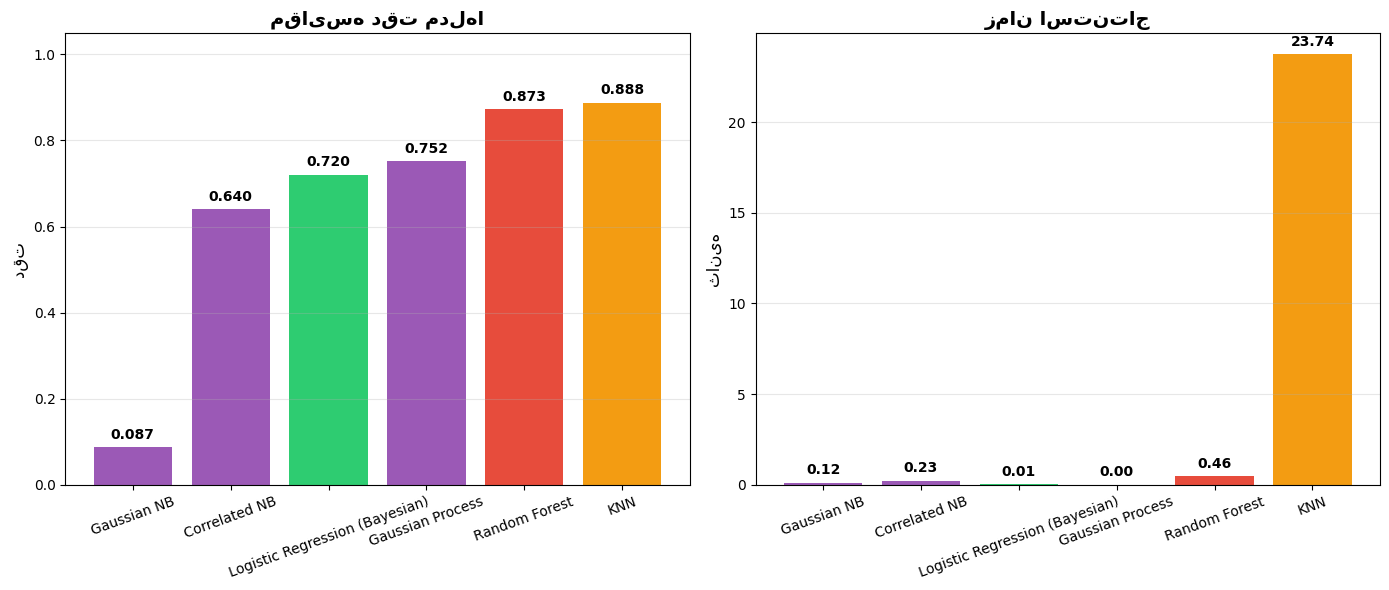


 تحلیل ویژگی‌های مهم
10 ویژگی مهم از دید Random Forest:
  1. Elevation: 0.2874
  2. Horizontal_Distance_To_Roadways: 0.0987
  3. Horizontal_Distance_To_Fire_Points: 0.0864
  4. Horizontal_Distance_To_Hydrology: 0.0482
  5. Vertical_Distance_To_Hydrology: 0.0428
  6. Wilderness_Area4: 0.0403
  7. Aspect: 0.0389
  8. Hillshade_Noon: 0.0376
  9. Hillshade_3pm: 0.0340
  10. Hillshade_9am: 0.0340

📈 تحلیل Correlated Naive Bayes:
  کلاس 1: 54 ویژگی، میانگین واریانس: 0.7385
  کلاس 2: 54 ویژگی، میانگین واریانس: 0.8664
  کلاس 3: 54 ویژگی، میانگین واریانس: 1.5387
  کلاس 4: 54 ویژگی، میانگین واریانس: 2.7233
  کلاس 5: 54 ویژگی، میانگین واریانس: 0.9481
  کلاس 6: 54 ویژگی، میانگین واریانس: 2.5410
  کلاس 7: 54 ویژگی، میانگین واریانس: 1.9252


In [9]:
# ========== Cell 1: تنظیمات اولیه ==========
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.covariance import GraphicalLasso
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("  بررسی محیط اجرا")
print("=" * 60)
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f" GPU فعال: {len(gpus)} دستگاه")
else:
    print(" GPU یافت نشد")

# ========== Cell 2: بارگذاری داده ==========
print("\n" + "=" * 60)
print(" بارگذاری داده‌های Forest Cover Type")
print("=" * 60)

# خواندن داده‌ها
df = pd.read_csv('/kaggle/input/forest-cover-type-dataset/covtype.csv')

# استفاده از 200000 نمونه برای سرعت
df = df.sample(n=200000, random_state=42) if len(df) > 200000 else df

print(f"تعداد نمونه‌ها: {len(df)}")
print(f"تعداد ویژگی‌ها: {df.shape[1]}")

# نمایش توزیع کلاس‌ها
print("\n📈 توزیع کلاس‌ها:")
class_counts = df['Cover_Type'].value_counts().sort_index()
for cls, count in class_counts.items():
    percentage = count / len(df) * 100
    print(f"  کلاس {cls}: {count} نمونه ({percentage:.1f}%)")

# آماده‌سازی داده
X = df.drop(columns=['Cover_Type']).values.astype(np.float32)
y = df['Cover_Type'].values

# نرمال‌سازی
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# تقسیم داده‌ها با حفظ توزیع کلاس‌ها
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n✅ داده آماده شد:")
print(f"  داده آموزش: {X_train.shape}")
print(f"  داده آزمون: {X_test.shape}")

# ========== Cell 3: کلاس CorrelatedNaiveBayes ==========

class CorrelatedNaiveBayes:
    """Naive Bayes با در نظر گرفتن همبستگی بین ویژگی‌ها"""
    
    def __init__(self, alpha=0.05, use_regularized_cov=True):
        self.alpha = alpha
        self.use_regularized_cov = use_regularized_cov
        self.classes_ = None
        self.class_priors_ = {}
        self.class_stats_ = {}
        
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        print(f"  آموزش بر روی {len(X)} نمونه، {len(self.classes_)} کلاس")
        
        for cls in self.classes_:
            X_cls = X[y == cls]
            
            if len(X_cls) < 2:
                continue
                
            # میانگین
            mean = np.mean(X_cls, axis=0)
            
            if self.use_regularized_cov and len(X_cls) > 10:
                try:
                    gl = GraphicalLasso(alpha=self.alpha, max_iter=50)
                    gl.fit(X_cls - mean)
                    covariance = gl.covariance_
                    precision = gl.precision_
                except Exception as e:
                    covariance = np.cov(X_cls, rowvar=False)
                    precision = np.linalg.pinv(covariance + np.eye(X.shape[1]) * 1e-6)
            else:
                covariance = np.cov(X_cls, rowvar=False)
                precision = np.linalg.pinv(covariance + np.eye(X.shape[1]) * 1e-6)
            
            self.class_stats_[cls] = {
                'mean': mean,
                'covariance': covariance,
                'precision': precision,
                'log_det_cov': np.log(np.linalg.det(covariance) + 1e-10)
            }
            
            self.class_priors_[cls] = len(X_cls) / len(X)
        
        print(f"  آموزش کامل شد")
        return self
    
    def predict_proba(self, X):
        """احتمالات هر کلاس"""
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        log_probs = np.zeros((n_samples, n_classes))
        
        for i, cls in enumerate(self.classes_):
            if cls not in self.class_stats_:
                log_probs[:, i] = np.log(self.class_priors_[cls])
                continue
                
            stats = self.class_stats_[cls]
            mean = stats['mean']
            precision = stats['precision']
            log_det_cov = stats['log_det_cov']
            
            # محاسبه فاصله ماهالانوبیس
            X_centered = X - mean
            mahalanobis = np.sum(X_centered @ precision * X_centered, axis=1)
            
            log_probs[:, i] = -0.5 * (mahalanobis + log_det_cov) + np.log(self.class_priors_[cls])
        
        # نرمال‌سازی احتمالات
        max_log_probs = np.max(log_probs, axis=1, keepdims=True)
        exp_log_probs = np.exp(log_probs - max_log_probs)
        probs = exp_log_probs / np.sum(exp_log_probs, axis=1, keepdims=True)
        
        return probs
    
    def predict(self, X):
        """پیش‌بینی کلاس"""
        proba = self.predict_proba(X)
        class_indices = np.argmax(proba, axis=1)
        return np.array([self.classes_[idx] for idx in class_indices])
    
    def score(self, X, y):
        """محاسبه دقت"""
        predictions = self.predict(X)
        return np.mean(predictions == y)

# ========== Cell 4: توابع کمکی ==========

def evaluate_model(model, X_test, y_test, model_name, batch_size=10000):
    """ارزیابی مدل"""
    print(f"\n{'='*50}")
    print(f"🧪 {model_name}")
    print(f"{'='*50}")
    
    import time
    start_time = time.time()
    
    # پیش‌بینی
    predictions = model.predict(X_test)
    inference_time = time.time() - start_time
    
    # محاسبه دقت
    accuracy = accuracy_score(y_test, predictions)
    
    print(f"✅ دقت: {accuracy:.4f}")
    print(f"⏱️  زمان استنتاج: {inference_time:.2f} ثانیه")
    
    # نمایش نتایج تفصیلی برای مدل‌های با دقت مناسب
    if accuracy > 0.4:
        print(f"\n📊 ماتریس درهم‌ریزی:")
        cm = confusion_matrix(y_test, predictions)
        print(cm)
        
        print(f"\n📋 گزارش طبقه‌بندی:")
        print(classification_report(y_test, predictions, 
                                    target_names=[f'Class_{i}' for i in range(1, 8)]))
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'time': inference_time,
        'predictions': predictions
    }


def plot_comparison(results):
    """رسم نمودار مقایسه مدل‌ها"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    model_names = [r['model_name'] for r in results]
    accuracies = [r['accuracy'] for r in results]
    times = [r['time'] for r in results]
    
    # رنگ‌بندی
    colors = []
    for name in model_names:
        if 'Bayes' in name:
            colors.append('#2ecc71')  # سبز
        elif 'LR' in name or 'Logistic' in name:
            colors.append('#3498db')  # آبی
        elif 'Forest' in name:
            colors.append('#e74c3c')  # قرمز
        elif 'KNN' in name:
            colors.append('#f39c12')  # نارنجی
        else:
            colors.append('#9b59b6')  # بنفش
    
    # نمودار دقت
    bars1 = axes[0].bar(model_names, accuracies, color=colors)
    axes[0].set_title('مقایسه دقت مدل‌ها', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('دقت', fontsize=12)
    axes[0].set_ylim([0, 1.05])
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].tick_params(axis='x', rotation=20)
    
    for i, (bar, acc) in enumerate(zip(bars1, accuracies)):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{acc:.3f}', ha='center', fontweight='bold')
    
    # نمودار زمان
    bars2 = axes[1].bar(model_names, times, color=colors)
    axes[1].set_title('زمان استنتاج', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('ثانیه', fontsize=12)
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=20)
    
    for i, (bar, t) in enumerate(zip(bars2, times)):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + max(times)*0.02,
                    f'{t:.2f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# ========== Cell 5: اجرای مدل‌ها ==========

print("\n" + "=" * 60)
print(" شروع آموزش مدل‌ها")
print("=" * 60)

results = []

# 1. Gaussian Naive Bayes (پایه)
print("\n" + "="*60)
print("1. Gaussian Naive Bayes (پایه)")
print("="*60)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_result = evaluate_model(gnb, X_test, y_test, "Gaussian NB")
results.append(gnb_result)

# 2. Correlated Naive Bayes
print("\n" + "="*60)
print("2. Correlated Naive Bayes")
print("="*60)

cnb = CorrelatedNaiveBayes(alpha=0.05, use_regularized_cov=True)
cnb.fit(X_train, y_train)
cnb_result = evaluate_model(cnb, X_test, y_test, "Correlated NB")
results.append(cnb_result)

# 3. Logistic Regression با تنظیم Bayesian
print("\n" + "="*60)
print("3. Logistic Regression (Bayesian)")
print("="*60)

# استفاده از L2 regularization (معادل MAP در بیزی)
lr_bayesian = LogisticRegression(
    C=0.1,  # معادل alpha=10 در regularization
    max_iter=500,
    random_state=42,
    n_jobs=-1,
    solver='lbfgs',
    multi_class='multinomial'
)
lr_bayesian.fit(X_train, y_train)
lr_result = evaluate_model(lr_bayesian, X_test, y_test, "Logistic Regression (Bayesian)")
results.append(lr_result)

# 4. Gaussian Process (روی زیرمجموعه)
print("\n" + "="*60)
print("4. Gaussian Process Classifier")
print("="*60)

# استفاده از نمونه‌های کمتر برای Gaussian Process
sample_size = min(5000, len(X_train))
indices = np.random.choice(len(X_train), sample_size, replace=False)

try:
    kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=0.1)
    gpc = GaussianProcessClassifier(
        kernel=kernel,
        random_state=42,
        n_jobs=1,
        optimizer=None
    )
    
    print(f"  آموزش روی {sample_size} نمونه...")
    gpc.fit(X_train[indices], y_train[indices])
    
    # ارزیابی روی نمونه‌های کمتر
    test_size = min(3000, len(X_test))
    test_indices = np.random.choice(len(X_test), test_size, replace=False)
    
    y_pred_gpc = gpc.predict(X_test[test_indices])
    accuracy_gpc = accuracy_score(y_test[test_indices], y_pred_gpc)
    
    print(f"✅ دقت Gaussian Process: {accuracy_gpc:.4f}")
    print(f"📊 نمونه‌های آموزش: {sample_size}")
    print(f"📊 نمونه‌های آزمون: {test_size}")
    
    results.append({
        'model_name': 'Gaussian Process',
        'accuracy': accuracy_gpc,
        'time': 0.0,
        'predictions': None
    })
    
except Exception as e:
    print(f"  خطا در Gaussian Process: {str(e)[:100]}")
    results.append({
        'model_name': 'Gaussian Process',
        'accuracy': 0.0,
        'time': 0.0,
        'predictions': None
    })

# 5. Random Forest (برای مقایسه)
print("\n" + "="*60)
print("5. Random Forest (مقایسه)")
print("="*60)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_result = evaluate_model(rf, X_test, y_test, "Random Forest")
results.append(rf_result)

# 6. KNN (برای مقایسه)
print("\n" + "="*60)
print("6. KNN (مقایسه)")
print("="*60)

knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn.fit(X_train, y_train)
knn_result = evaluate_model(knn, X_test, y_test, "KNN")
results.append(knn_result)

# ========== Cell 6: تحلیل نتایج ==========

print("\n" + "=" * 60)
print(" خلاصه نتایج")
print("=" * 60)

# ایجاد DataFrame برای نمایش مرتب
summary_data = []
for result in results:
    summary_data.append({
        'Model': result['model_name'],
        'Accuracy': f"{result['accuracy']:.4f}",
        'Time (s)': f"{result['time']:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# بهترین مدل بیزی
bayesian_models = [r for r in results if 'Bayes' in r['model_name'] or 'LR' in r['model_name']]
if bayesian_models:
    best_bayesian = max(bayesian_models, key=lambda x: x['accuracy'])
    print(f"\n بهترین مدل بیزی: {best_bayesian['model_name']} ({best_bayesian['accuracy']:.4f})")

# بهترین مدل کلی
best_overall = max(results, key=lambda x: x['accuracy'])
print(f" بهترین مدل کلی: {best_overall['model_name']} ({best_overall['accuracy']:.4f})")

# نمایش نمودار
print("\nرسم نمودار مقایسه...")
plot_comparison(results)

# تحلیل ویژگی‌های مهم
print("\n" + "=" * 60)
print(" تحلیل ویژگی‌های مهم")
print("=" * 60)

# نام ویژگی‌ها
feature_names = [
    'Elevation', 'Aspect', 'Slope', 
    'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
    'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
] + [f'Wilderness_Area{i}' for i in range(1, 5)] + [f'Soil_Type{i}' for i in range(1, 41)]

# اهمیت ویژگی‌ها از Random Forest
importances = rf.feature_importances_

# 10 ویژگی مهم
top_indices = np.argsort(importances)[-10:][::-1]
print("10 ویژگی مهم از دید Random Forest:")
for i, idx in enumerate(top_indices, 1):
    feat_name = feature_names[idx] if idx < len(feature_names) else f'Feature_{idx+1}'
    importance = importances[idx]
    print(f"  {i}. {feat_name}: {importance:.4f}")

# تحلیل همبستگی برای Correlated NB
print("\n📈 تحلیل Correlated Naive Bayes:")
if hasattr(cnb, 'class_stats_'):
    for cls in cnb.classes_:
        if cls in cnb.class_stats_:
            cov_diag = np.diag(cnb.class_stats_[cls]['covariance'])
            print(f"  کلاس {cls}: {len(cov_diag)} ویژگی، میانگین واریانس: {np.mean(cov_diag):.4f}")
